In [1]:
# import data
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
from graphdot import Graph
from graphdot.kernel.marginalized import MarginalizedGraphKernel
from graphdot.kernel.basekernel import TensorProduct
from graphdot.kernel.basekernel import SquareExponential
from graphdot.kernel.basekernel import KroneckerDelta
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from app.smiles import smiles2graph

RDKit WARNING: [23:56:33] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
def evaluate(df,target,model,plot=True):
    y_pred = model.predict(df['graph'])
    if plot:
        plt.scatter(y_pred, df[target], s=2)
        plt.title(target + ' prediction')
        plt.plot([df[target].min(), df[target].max()],[df[target].min(), df[target].max()])
        plt.xlabel('simulation')
        plt.ylabel('prediction')
    # R2
    r2 = model.score(df['graph'],df[target])
    # MSE
    mse = mean_squared_error(y_pred, df[target])
    # variance explained
    ex_var = explained_variance_score(y_pred, df[target])
    print("R-square:%.3f\tMSE:%.3g\texplained_variance:%.3f" % (r2, mse, ex_var))
    return {'r2':r2, 'mse':mse, 'ex_var':ex_var}

In [3]:
import networkx as nx
from rdkit.Chem import MolFromSmiles
def smile2graph(smile):
    mol = MolFromSmiles(smile)

    if mol is not None:
        g = nx.Graph()

        for i, atom in enumerate(mol.GetAtoms()):
            g.add_node(i)
            #g.nodes[i]['symbol'] = atom.GetAtomicNum()
            g.nodes[i]['charge'] = atom.GetFormalCharge()
            g.nodes[i]['hcount'] = atom.GetTotalNumHs()
            g.nodes[i]['hybridization'] = atom.GetHybridization()
            g.nodes[i]['aromatic'] = atom.GetIsAromatic()
            g.nodes[i]['chiral'] = atom.GetChiralTag()

        for bond in mol.GetBonds():
            ij = (bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
            g.add_edge(*ij)
            g.edges[ij]['order'] = bond.GetBondType()
            g.edges[ij]['aromatic'] = bond.GetIsAromatic()
            g.edges[ij]['conjugated'] = bond.GetIsConjugated()
            g.edges[ij]['stereo'] = bond.GetStereo()
            g.edges[ij]['inring'] = bond.IsInRing()

        return Graph.from_networkx(g)
    else:
        return None

In [4]:
# defining kernel
class NormalizedKernel(MarginalizedGraphKernel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def __normalize(self, X, Y, R):
        if type(R) is tuple:
            d = np.diag(R[0])**-0.5
            K = np.diag(d).dot(R[0]).dot(np.diag(d))
            return (K, R[1])
        else:
            if Y is None:
                # square matrix
                d = np.diag(R)**-0.5
                K = np.diag(d).dot(R).dot(np.diag(d))
            else:
                # rectangular matrix, must have X and Y
                diag_X = super().diag(X)**-0.5
                diag_Y = super().diag(Y)**-0.5
                K = np.diag(diag_X).dot(R).dot(np.diag(diag_Y))
            return K
    def __call__(self, X, Y=None, *args, **kwargs):
        R = super().__call__(X, Y, *args, **kwargs)
        return self.__normalize(X, Y, R)

#initializing kernel
knode = TensorProduct(aromatic=KroneckerDelta(0.8),
                      charge=SquareExponential(1.0),
                      hcount=SquareExponential(1.0))

kedge = TensorProduct(order=KroneckerDelta(0.5))

normal_kernel = NormalizedKernel(knode, kedge, q=0.05)
kernel = MarginalizedGraphKernel(knode, kedge, q=0.05)

In [6]:
df = pd.read_csv('../data/result-ML-CH-critical.txt', sep=' ')
df['graph'] = [smile2graph(i) for i in df['SMILES']]

In [7]:
df.head()

,SMILES,tc,dc,graph
0,CCCC,414.5,0.2269,"<Graph(nodes={'!i': [0,1,2,3], 'aromatic': [Fa..."
1,CC(C)C,407.2,0.2291,"<Graph(nodes={'!i': [0,1,2,3], 'aromatic': [Fa..."
2,CCCCC,459.5,0.2320,"<Graph(nodes={'!i': [0,1,2,3,4], 'aromatic': [..."
3,CCC(C)C,455.0,0.2328,"<Graph(nodes={'!i': [0,1,2,3,4], 'aromatic': [..."
4,CC(C)(C)C,435.9,0.2366,"<Graph(nodes={'!i': [0,1,2,3,4], 'aromatic': [..."


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [21]:
scaler.fit_transform(np.array(df['dc']).reshape(-1,1)).std()

1.0

In [29]:
scaler.transform(df['tc'].values.reshape(-1,1)).flatten()

array([24882.03309324, 24443.55115234, 27585.00396185, ...,
       32071.93560374, 30864.60861576, 34744.87346269])

# einsum/broadcast test

In [30]:
# load some real data

In [65]:
df = pd.read_csv('../data/result-ML-All-critical.txt', sep=' ')
df['graph'] = df['SMILES'].apply(smile2graph)

In [67]:
len(df['graph'])

3617

In [82]:
%timeit a_kernel = kernel(list(df['graph']))

29.2 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
diag_d = np.diag(a_kernel) ** -0.5

In [71]:
#einsum
%timeit K = np.einsum("ij,i,j->ij", a_kernel, diag_d, diag_d)

18.8 ms ± 74.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [81]:
#broadcasting
%timeit K = diag_d * a_kernel * diag_d

21.2 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
a = np.array([[10,2],[4,9]])

In [76]:
d_a = np.diag(a) ** -0.5

In [77]:
a

array([[10,  2],
       [ 4,  9]])

In [80]:
%timeit d_a * a * d_a.reshape(-1,1)

array([[1.        , 0.21081851],
       [0.42163702, 1.        ]])

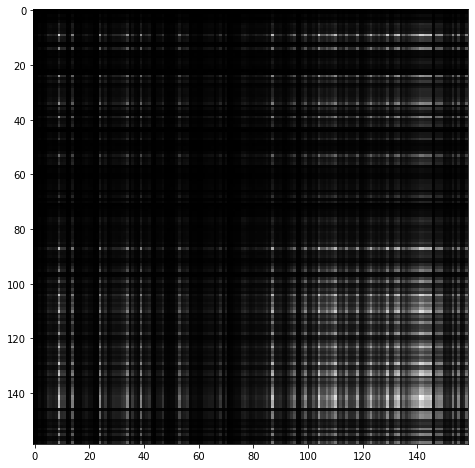

In [86]:
plt.figure(figsize=(8,8))
plt.imshow(K, cmap=plt.cm.gray)

# prediction test for T P relationship

In [2]:
import sys
import argparse

sys.path.append('.')
sys.path.append('..')
from app.kernel import *
from app.smiles import *
from app.ActiveLearning import *
from app.Nystrom import NystromGaussianProcessRegressor

In [3]:
optimizer = None
print('***\tStart: Reading input.\t***\n')
kernel_config = KernelConfig(save_mem=False, property='density')

***	Start: Reading input.	***



In [4]:
df_all = pd.read_csv('../data/result-ML-All-npt.txt', sep=' ')

In [5]:
input_file = '../data/density-npt-subset.csv'
train_X, train_Y, train_smiles_list = get_XY_from_file(input_file, kernel_config,
                                                               ratio=Config.TrainingSetSelectRule.RANDOM_Para['ratio'],
                                                               seed=233)

reading existing data file: data/.pkl


In [8]:
test_X, test_Y = get_XY_from_file('../data/result-ML-All-npt.txt', kernel_config, remove_smiles=train_smiles_list, seed=233)

reading existing data file: data/.pkl


In [9]:
len(test_X)

4032

In [15]:
a = kernel_config.kernel(test_X[:500])

(array([22288., 13591.,  9503.,  8260.,  8720.,  8658.,  7669.,  5954.,
         5461.,  5259.,  5020.,  4719.,  4528.,  4047.,  3509.,  2745.,
         2131.,  1511.,   881.,   296.]),
 array([9.7044493e-04, 5.0650354e-02, 1.0033026e-01, 1.5001017e-01,
        1.9969009e-01, 2.4936999e-01, 2.9904991e-01, 3.4872982e-01,
        3.9840972e-01, 4.4808963e-01, 4.9776953e-01, 5.4744947e-01,
        5.9712934e-01, 6.4680928e-01, 6.9648921e-01, 7.4616909e-01,
        7.9584903e-01, 8.4552890e-01, 8.9520884e-01, 9.4488871e-01,
        9.9456865e-01], dtype=float32),
 <a list of 20 Patch objects>)

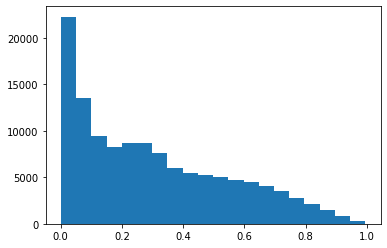

In [16]:
plt.hist(a[np.triu_indices(500, k = 1)], bins=20)

In [17]:
model = gp.GaussianProcessRegressor(kernel=kernel_config.kernel, random_state=0, optimizer=optimizer,
                                            normalize_y=True, alpha=0.07).fit(train_X[:500], train_Y[:500])

In [21]:
y_pred, y_std = model.predict(test_X, return_std=True)
# R2
r2 = r2_score(y_pred, test_Y)
# MSE
mse = mean_squared_error(y_pred, test_Y)
# variance explained
ex_var = explained_variance_score(y_pred, test_Y)

In [19]:
y_pred, y_std = model.predict(train_X[:500], return_std=True)

In [20]:
y_std

array([1.01763612, 1.0113001 , 1.00945531, 1.00377219, 1.00708549,
       1.01016169, 1.00939739, 1.0050954 , 1.00789921, 1.01215423,
       1.00872352, 1.00835294, 1.02490284, 1.01280275, 1.00585899,
       1.01502186, 1.01810266, 1.00421086, 1.00879328, 1.01576792,
       1.01322658, 1.01063852, 1.02023053, 1.01157581, 1.0135736 ,
       1.00634413, 1.02356221, 1.00932103, 1.00604211, 1.01649825,
       1.00751934, 1.01103753, 1.01077917, 1.00991887, 1.01182119,
       1.00838127, 1.0024548 , 1.01477346, 1.01206903, 1.00660336,
       1.01028266, 1.00689727, 1.01269981, 1.01662949, 1.00398372,
       1.01503176, 1.00822282, 1.01168547, 1.01240609, 1.01888746,
       1.01250033, 1.00339989, 1.00886747, 1.01146318, 1.01030863,
       1.00707261, 1.01203794, 1.00766918, 1.00945482, 1.00745449,
       1.00546186, 1.01639077, 1.00845062, 1.00825957, 1.0142558 ,
       1.00786379, 1.0089369 , 1.02186744, 1.01124327, 1.00572953,
       1.00880509, 1.0184546 , 1.01198299, 1.00622551, 1.00945

In [56]:
test_mol = df_all.sample(n=1)['SMILES'].values[0]

test_mol in train_smiles_list

False

In [67]:
test_mol_df['graph'] = 

,SMILES,T,P,density,einter,compress
170296,CC(c1cccc(c1O)C(C)(C)C)(C)C,337,1,0.9081,-66.53,0.000079
170297,CC(c1cccc(c1O)C(C)(C)C)(C)C,375,1,0.8832,-63.64,0.000096
170298,CC(c1cccc(c1O)C(C)(C)C)(C)C,412,1,0.8543,-60.38,0.000108
170299,CC(c1cccc(c1O)C(C)(C)C)(C)C,450,1,0.8233,-57.14,0.000173
170300,CC(c1cccc(c1O)C(C)(C)C)(C)C,487,1,0.7961,-54.34,0.000208
170301,CC(c1cccc(c1O)C(C)(C)C)(C)C,525,1,0.7644,-51.23,0.000319
170302,CC(c1cccc(c1O)C(C)(C)C)(C)C,562,1,0.7294,-48.02,0.000458
170303,CC(c1cccc(c1O)C(C)(C)C)(C)C,600,1,0.6946,-44.90,0.000628
170304,CC(c1cccc(c1O)C(C)(C)C)(C)C,337,50,0.9157,-67.22,0.000065
170305,CC(c1cccc(c1O)C(C)(C)C)(C)C,375,50,0.8859,-63.84,0.000093


In [80]:
test_mol_df = df_all[df_all['SMILES']==test_mol]
test_mol_df['graph'] = test_mol_df['SMILES'].apply(smiles2graph)
y_pred, y_std = model.predict(test_mol_df[['graph','T','P']], return_std=True)
test_mol_df['y_pred'] = y_pred
test_mol_df['y_std'] = y_std

/home/henryliu/anaconda3/envs/graphdot/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/henryliu/anaconda3/envs/graphdot/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/henryliu/anaconda3/envs/graphdot/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [62]:
%matplotlib inline
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


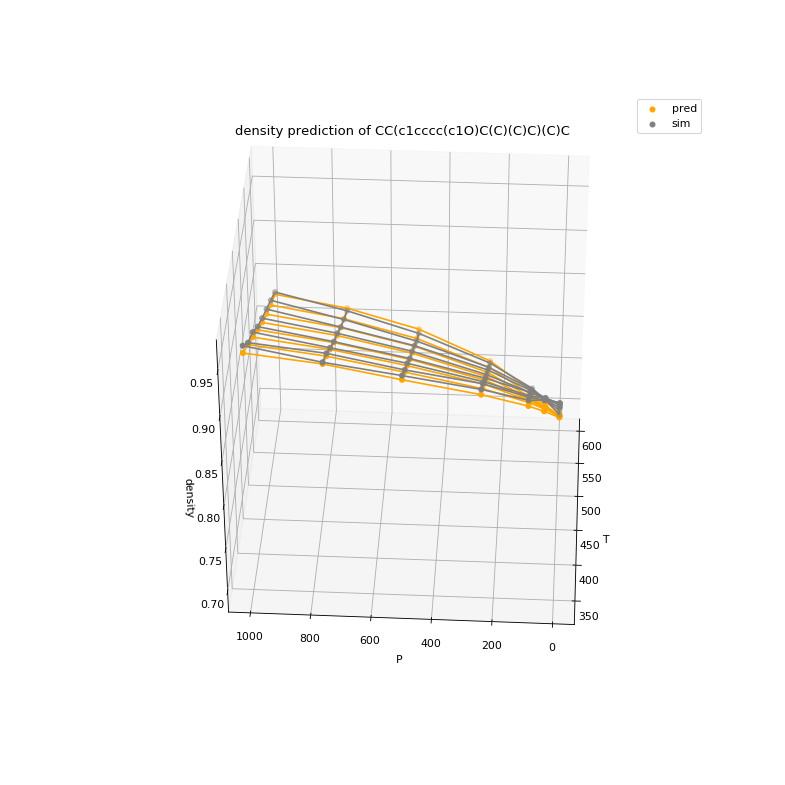

Text(0.5, 0.92, 'density prediction of CC(c1cccc(c1O)C(C)(C)C)(C)C')

In [88]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = test_mol_df['T'].values.reshape(7,-1)
y = test_mol_df['P'].values.reshape(7,-1)
z = test_mol_df['y_pred'].values.reshape(7,-1)
z2 = test_mol_df['density'].values.reshape(7,-1)
ax.scatter3D(x, y, z, c='orange', label='pred')
ax.plot_wireframe(X=x, Y=y, Z=z, linestyles='-', color='orange')
ax.scatter3D(x, y, z2, color='grey', label='sim')
ax.plot_wireframe(X=x, Y=y, Z=z2, linestyles='-', color='grey')
ax.view_init(elev=10., azim=200)
ax.set_xlabel('T')
ax.set_ylabel('P')
ax.set_zlabel('density')
plt.legend()
plt.title('density prediction of %s' % test_mol)

In [75]:
some_test_mol

,SMILES,T,P,density,einter,compress
170296,CC(c1cccc(c1O)C(C)(C)C)(C)C,337,1,0.9081,-66.53,0.000079
170297,CC(c1cccc(c1O)C(C)(C)C)(C)C,375,1,0.8832,-63.64,0.000096
170298,CC(c1cccc(c1O)C(C)(C)C)(C)C,412,1,0.8543,-60.38,0.000108
170299,CC(c1cccc(c1O)C(C)(C)C)(C)C,450,1,0.8233,-57.14,0.000173
170300,CC(c1cccc(c1O)C(C)(C)C)(C)C,487,1,0.7961,-54.34,0.000208
170301,CC(c1cccc(c1O)C(C)(C)C)(C)C,525,1,0.7644,-51.23,0.000319
170302,CC(c1cccc(c1O)C(C)(C)C)(C)C,562,1,0.7294,-48.02,0.000458
170303,CC(c1cccc(c1O)C(C)(C)C)(C)C,600,1,0.6946,-44.90,0.000628
170304,CC(c1cccc(c1O)C(C)(C)C)(C)C,337,50,0.9157,-67.22,0.000065
170305,CC(c1cccc(c1O)C(C)(C)C)(C)C,375,50,0.8859,-63.84,0.000093
